# Active Learning Notebook

Use the large data set with active learning.

## Notes 04-27-2022

Did some debugging. The linear model works right now. The GP model is not working currently so have asked Berkay if there are parameters that give some good values. Random runs throught the `multiple_rounds` function, but the accuracy is extremely high at the very start 0.94. This is with 30 training samples. I'm wondering if the data is somehow sorted so that the first 1000 samples that I'm currently using for testing are similar and hence the high accuracy even with only 30 sample for training. Next step is to pre-shuffle the data and see if this makes the early stages of the random have a lower accuracy. 

TODO:

 - [x] pre-shuffle the data (as you recently did in the pace visualization repository).
 - [ ] try and get the GPR model working
 - [ ] examine efficiency
 - [ ] batch jobs. don't relearn so frequently
 - [ ] parallel

In [276]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do, merge_with
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence
from active import gsx_query, gsy_query, igs_query, multiple_rounds, three_way_split, flatten

import dask.array as da

## Load the data

In [217]:
data = np.load('data_shuffled.npz')

In [218]:
x_data = data['x_data']
y_data = data['y_data'].reshape(-1)

In [219]:
print(x_data.shape)
print(y_data.shape)

(8900, 132651)
(8900,)


## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [278]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], 51, 51,51)
        )),    
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=10, correlations=[(0, 0)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3))
    )

In [308]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) + WhiteKernel()
    #kernel = RBF() + RBF(length_scale=np.ones(56)) + WhiteKernel()
    #kernel = RBF(length_scale=20.2) + WhiteKernel(noise_level=0.00472)
    #kernel = RBF(length_scale=1.) + WhiteKernel()
    #kernel = RBF() + WhiteKernel()
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    #kernel = RBF(length_scale=4.38) + WhiteKernel(noise_level=0.00593)
    #kernel = Matern(length_scale=1)
    #regressor = GaussianProcessRegressor(kernel=kernel)#, alpha=1e-6)#, normalize_y=True)
    #regressor = GaussianProcessRegressor(kernel=kernel)
    return Pipeline(steps=pca_steps() + (
#        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor),
    ))

def make_linear_model():
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))

def pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [222]:
@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

## Helper Functions

In [223]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

## Set up the active learners

One is a GPR using the maximum std and the other is random

In [340]:
from active import make_igs, make_gsx, make_gsy, make_bayes, make_uncertainty, make_ensemble, make_random

distance_transformer = lambda x: pca_model().fit_transform(x)


def make_learners(x_train, y_train):
    return dict(
#        uncertainty=make_uncertainty(make_gp_model, x_train, y_train),
        random=make_random(make_gp_model, x_train, y_train),
#        ensemble=make_ensemble(x_train, y_train),
#        bayes=make_bayes(make_gp_model, x_train, y_train),
#        gsx=make_gsx(distance_transformer)(make_linear_model, x_train, y_train),
#        gsy=make_gsy(make_linear_model, x_train, y_train),
#        igs=make_igs(distance_transformer)(make_linear_model, x_train, y_train)
    )

random_learner = make_random(make_gp_model, x_train, y_train)

## Check the data

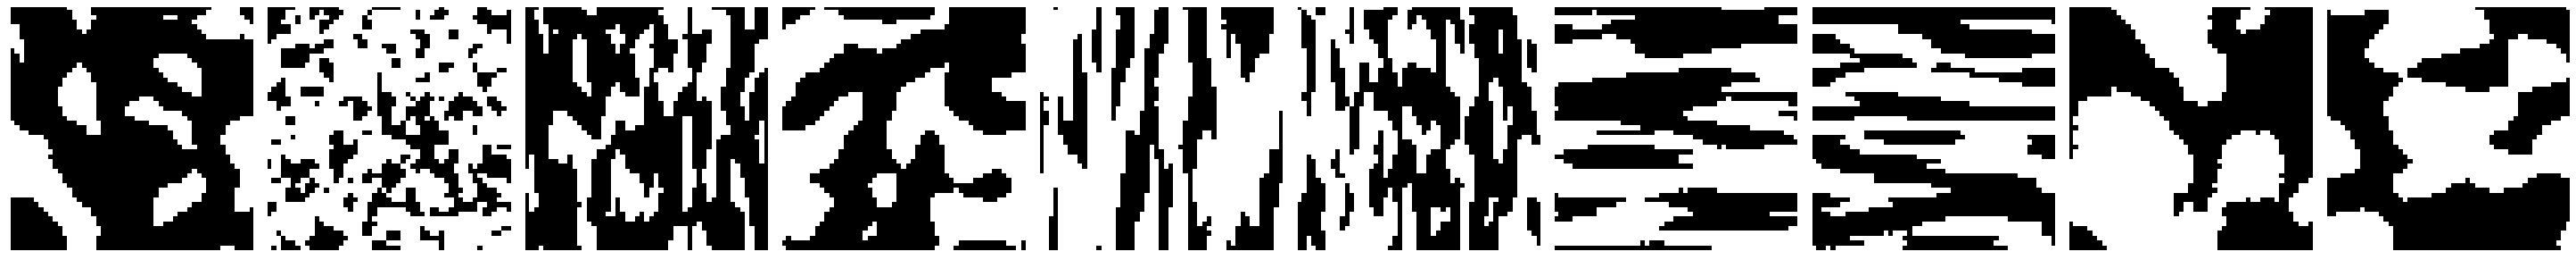

In [225]:
plot_microstructures(*x_data[:10].reshape(10, 51, 51, 51)[:, :, :, 0], cmap='gray', colorbar=False);

In [328]:
n_use = 1000
props = (0.8, 0.18)

x_pool, x_test, x_train, y_pool, y_test, y_train = three_way_split(x_data[:n_use], y_data[:n_use], props, None)

In [329]:
print(x_pool.shape)
print(x_test.shape)
print(x_train.shape)

(800, 132651)
(180, 132651)
(20, 132651)


In [330]:
print(y_pool.shape)
print(y_test.shape)
print(y_train.shape)

(800,)
(180,)
(20,)


## Test the model

In [331]:
model = make_gp_model()
#model = make_linear_model()

In [332]:
model.fit(x_train, y_train)

Pipeline(steps=[('reshape',
                 GenericTransformer(func=<function pca_steps.<locals>.<lambda> at 0x7f92c756e670>)),
                ('discritize', PrimitiveTransformer()),
                ('correlations',
                 TwoPointCorrelation(correlations=[(0, 0)], cutoff=10)),
                ('flatten',
                 GenericTransformer(func=<function pca_steps.<locals>.<lambda> at 0x7f92c756e310>)),
                ('pca', IncrementalPCA(n_components=3)),
                ('regressor',
                 GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=10))])

In [333]:
y_train_predict = model.predict(x_train)

In [334]:
y_test_predict = model.predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

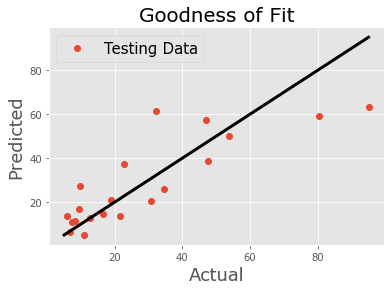

In [335]:
plot_parity(y_train, y_train_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

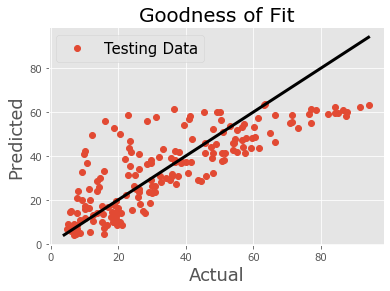

In [336]:
plot_parity(y_test, y_test_predict)

In [344]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y_test_predict))
#print(y_test.shape)
#print(y_test)
print(model.score(x_test, y_test))

0.6292903991069115
0.6292903991069115


## Run the learners

In [338]:
scores = multiple_rounds(x_data[:n_use], y_data[:n_use], 1, 30, make_learners, oracle_func, props)

evaluating random


100%|██████████| 30/30 [02:30<00:00,  5.00s/it]


In [339]:
scores


{'random': (array([ 0.85138909, -0.08698856, -0.03713712,  0.87531828,  0.88663354,
          0.89196135,  0.84875733,  0.84487646,  0.87902882,  0.86255135,
         -0.00512397,  0.85110648,  0.8241965 ,  0.82709585,  0.61190579,
         -0.00211859,  0.82854455,  0.8599785 ,  0.79788255,  0.81335599,
          0.83125758,  0.89707252,  0.84381052,  0.84837045,  0.86059883,
          0.82204144,  0.82579239,  0.83051567,  0.8100553 ,  0.79624862,
          0.79536141]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))}


## The results

(0.0, 1.0)

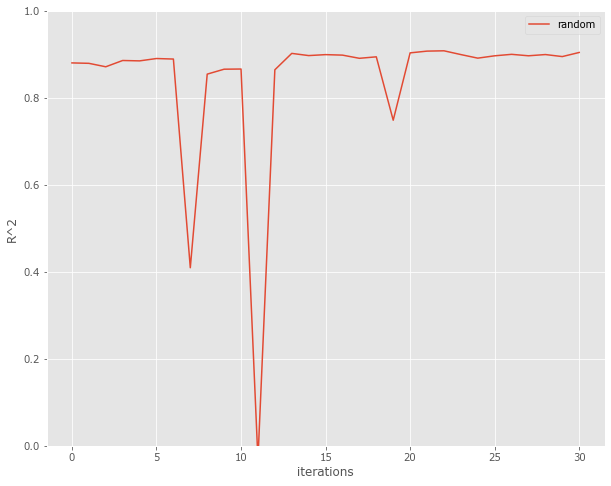

In [320]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0, 1)

(0.9, 1.0)

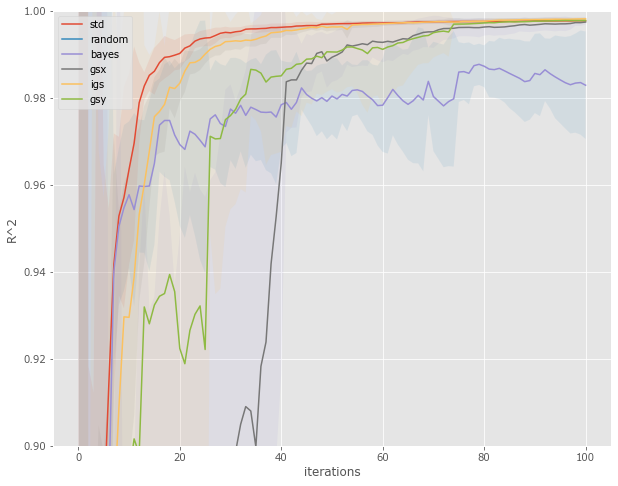

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.9, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

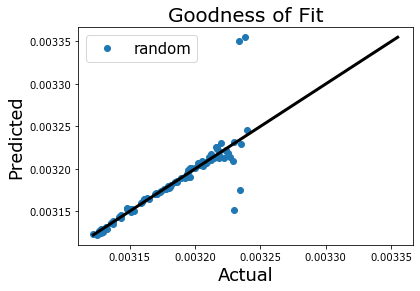

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

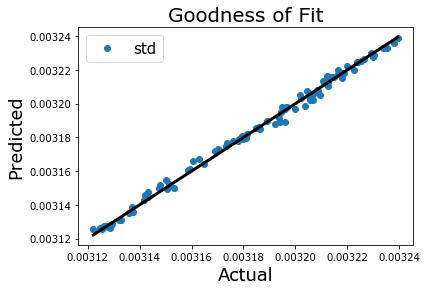

In [90]:
plot_parity(y_test, y_pred_std, label='std')